In [ ]:
# TO RUN
# from micecat import *
# run_micecat_batch(2,0~8, run_type='1h',  Nstack=100, Mhcut=1e14, R200cut=0, zcut=0.15)

# from stack import *
# run_stacking(2,4~8,filt_order=5)

# from micecat_auto import *
# run_micecat_auto_batch(2, 0~9, filt_order_arr=[5], 
# mag_stack=[0,1,2,3], Mhcut=1e14, R200cut=0, zcut=0.15)
# run_micecat_auto_batch(2, 0~9, filt_order_arr=[5], 
# mag_stack=[0,1,2,3], Mhcut=1e14, R200cut=0, zcut=0.15,istart=200)

In [25]:
# from run_fit import *
# inst = 1-2
# ifield=4-8
# im = 0-3
# filt_order = 3
# fit_stacking_mcmc(inst, ifield, im ,filt_order).run_mcmc()
# joint_fit_mcmc(inst,im,filt_order).run_mcmc()
# fit_stacking_mcmc(inst, ifield, im ,filt_order).run_mcmc_2par()
# joint_fit_mcmc(inst,im,filt_order).run_mcmc_2par()

# fit_stacking_mcmc(1,6,0,3,modify_cov=True).run_mcmc(savename='mcmc_3par_BootesB_m16_17_modcov.npy')

In [ ]:
# from run_fit import *
# fit_stacking_mcmc(1, 4-8, 0 ,3, subsub=True).run_mcmc()
# fit_stacking_mcmc(1, 4-8, 0 ,3, subsub=True).run_mcmc_2par()
# joint_fit_mcmc(1,0,3,subsub=True).run_mcmc()
# joint_fit_mcmc(1,0,3,subsub=True).run_mcmc_2par()

# 3 params

### corner

In [31]:
from run_fit import *
import corner
from PIL import Image

inst = 1

for ifield in [0,4,5,6,7,8]:
    if ifield==0:
        truths_arr = []
    for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
        subsub = True if im==0 else False
        R200 = gal_profile_model().Wang19_profile(0,im)['params']['R200']
        xe2_W19 = gal_profile_model().Wang19_profile(0,3)['params']['sersic2'][2]
        Re2_W19 = R200 * xe2_W19
        
        if ifield==0:
            savedir = mypaths['alldat'] + 'TM' + str(inst) + '/'
            savename = 'mcmc_3par_joint' + \
            '_m' + str(m_min) + '_' + str(m_max) + '.npy'
        else:
            savedir = mypaths['alldat'] + 'TM' + str(inst) + '/'
            savename = 'mcmc_3par_' + fieldnamedict[ifield] + \
            '_m' + str(m_min) + '_' + str(m_max) + '.npy'

        if subsub:
            savename = savename[:-4] + '_sub.npy'

        samples = np.load(savedir + savename)
        steps, nwalkers, nparams = samples.shape

        flatsamps = samples.copy()
        flatsamps[:,:,0] = flatsamps[:,:,0] * R200
        # chain rejection
        chain_use_idx = []
        Nchain = flatsamps.shape[1]
        for i in range(Nchain):
            if not np.any(flatsamps[100:,i,1]>100):
                chain_use_idx.append(i)
        flatsamps = flatsamps[150:,chain_use_idx,:].reshape((-1,3))

        bins0 = np.linspace(np.min(flatsamps[:,0]), np.max(flatsamps[:,0]), 20)
        bins1 = np.linspace(np.min(flatsamps[:,1]), np.max(flatsamps[:,1]), 20)
        bins2 = np.linspace(np.min(flatsamps[:,2]), np.max(flatsamps[:,2]), 20)
        
        if ifield==0:
            truths_arr.append(np.median(flatsamps, axis=0))

        levels= 1.0 - np.exp(-0.5 * np.arange(1, 2.1, 1) ** 2)
        figure = corner.corner(flatsamps, levels = levels,fill_contours=True,plot_datapoints=False,
                               bins=[bins0, bins1, bins2],label_kwargs={'fontsize':'xx-large'},
                               range=[(0,5),(0,20),(0,200)],
                               title_kwargs={'fontsize':'x-large'},
                               show_titles=True,labels=["$R_{e_2}$", r"$A_{\rm 1h}$", r"$A_{\rm 2h}$"],
                               truths=[Re2_W19,1,1])
        if ifield==0:
            plt.savefig('plots/TM%d/mcmc_joint_m%d_%d.png'\
                        %(inst,m_min, m_max), dpi=150)
        else:
            plt.savefig('plots/TM%d/mcmc_%s_m%d_%d.png'\
                        %(inst,fieldnamedict[ifield], m_min, m_max), dpi=150)

        plt.close()
        

#combine four mag plots into one plot
for ifield in [0,4,5,6,7,8]:
    result = Image.new("RGB", (3200,800))    
    for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
        fieldname = 'joint' if ifield==0 else fieldnamedict[ifield]
        fname = 'plots/TM%d/mcmc_%s_m%d_%d.png'\
                        %(inst, fieldname, m_min, m_max)
        path = os.path.expanduser(fname)
        img = Image.open(path)
        img.thumbnail((800, 800), Image.ANTIALIAS)
        x = im * 800
        y = 0
        w, h = img.size
        result.paste(img, (x, y, x + w, y + h))
        os.remove(fname)
    
    result.save(os.path.expanduser('plots/TM%d/mcmc_%s_3par.png'%(inst,fieldname)))

In [33]:
from run_fit import *
import corner
from PIL import Image

inst = 1
for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
    subsub = True if im==0 else False
    figure1, ax = plt.subplots(3,3,figsize=(12,12))
    figure2, ax = plt.subplots(3,3,figsize=(12,12))

    R200 = gal_profile_model().Wang19_profile(0,im)['params']['R200']
    xe2_W19 = gal_profile_model().Wang19_profile(0,3)['params']['sersic2'][2]
    Re2_W19 = R200 * xe2_W19
    for ifield in [4,5,6,7,8,0]:
#         if im==0 and ifield==0:
#             # the coner plot fail on this one
#             continue
        if ifield==0:
            savedir = mypaths['alldat'] + 'TM' + str(inst) + '/'
            savename = 'mcmc_3par_joint' + \
            '_m' + str(m_min) + '_' + str(m_max) + '.npy'
            c = 'k'
        else:
            savedir = mypaths['alldat'] + 'TM' + str(inst) + '/'
            savename = 'mcmc_3par_' + fieldnamedict[ifield] + \
            '_m' + str(m_min) + '_' + str(m_max) + '.npy'
            c = 'C' + str(ifield-4)

        if subsub:
            savename = savename[:-4] + '_sub.npy'

        samples = np.load(savedir + savename)
        steps, nwalkers, nparams = samples.shape

        flatsamps = samples.copy()
        flatsamps[:,:,0] = flatsamps[:,:,0] * R200
        # chain rejection
        chain_use_idx = []
        Nchain = flatsamps.shape[1]
        for i in range(Nchain):
            if not np.any(flatsamps[100:,i,1]>100):
                chain_use_idx.append(i)
        flatsamps = flatsamps[150:,chain_use_idx,:].reshape((-1,3))

        bins0 = np.linspace(np.min(flatsamps[:,0]), np.max(flatsamps[:,0]), 20)
        bins1 = np.linspace(np.min(flatsamps[:,1]), np.max(flatsamps[:,1]), 20)
        bins2 = np.linspace(np.min(flatsamps[:,2]), np.max(flatsamps[:,2]), 20)
        
        levels= 1.0 - np.exp(-0.5 * np.array([1]) ** 2)
        figure = corner.corner(flatsamps, levels = levels,fill_contours=False,color=c,
                               plot_datapoints=False,
                               bins=[bins0, bins1, bins2],label_kwargs={'fontsize':'xx-large'},
                               range=[(0,5),(0,20),(0,200)],
                               title_kwargs={'fontsize':'x-large'},
                               show_titles=True,labels=["$R_{e_2}$", r"$A_{\rm 1h}$", r"$A_{\rm 2h}$"],
                               fig=figure1)

        levels= 1.0 - np.exp(-0.5 * np.array([2]) ** 2)
        figure = corner.corner(flatsamps, levels = levels,fill_contours=False,color=c,
                               plot_datapoints=False,
                               bins=[bins0, bins1, bins2],label_kwargs={'fontsize':'xx-large'},
                               range=[(0,5),(0,20),(0,200)],
                               title_kwargs={'fontsize':'x-large'},
                               show_titles=True,labels=["$R_{e_2}$", r"$A_{\rm 1h}$", r"$A_{\rm 2h}$"],
                               fig=figure2)
        
    figure1.savefig('plots/TM%d/mcmc_m%d_%d_1sig.png'\
                %(inst, m_min, m_max), dpi=150)
    figure2.savefig('plots/TM%d/mcmc_m%d_%d_2sig.png'\
                %(inst, m_min, m_max), dpi=150)
    
    plt.close(figure1)
    plt.close(figure2)
#combine four mag plots into one plot
result = Image.new("RGB", (3200,800))    
for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
    fname = 'plots/TM%d/mcmc_m%d_%d_1sig.png'\
                    %(inst, m_min, m_max)
    path = os.path.expanduser(fname)
    img = Image.open(path)
    img.thumbnail((800, 800), Image.ANTIALIAS)
    x = im * 800
    y = 0
    w, h = img.size
    result.paste(img, (x, y, x + w, y + h))
    os.remove(fname)
    
    result.save(os.path.expanduser('plots/TM%d/mcmc_1sig_3par.png'%(inst)))

result = Image.new("RGB", (3200,800))    
for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):    
    fname = 'plots/TM%d/mcmc_m%d_%d_2sig.png'\
                    %(inst, m_min, m_max)
    path = os.path.expanduser(fname)
    img = Image.open(path)
    img.thumbnail((800, 800), Image.ANTIALIAS)
    x = im * 800
    y = 0
    w, h = img.size
    result.paste(img, (x, y, x + w, y + h))
    os.remove(fname)
    
    result.save(os.path.expanduser('plots/TM%d/mcmc_2sig_3par.png'%(inst)))

### 1D profile

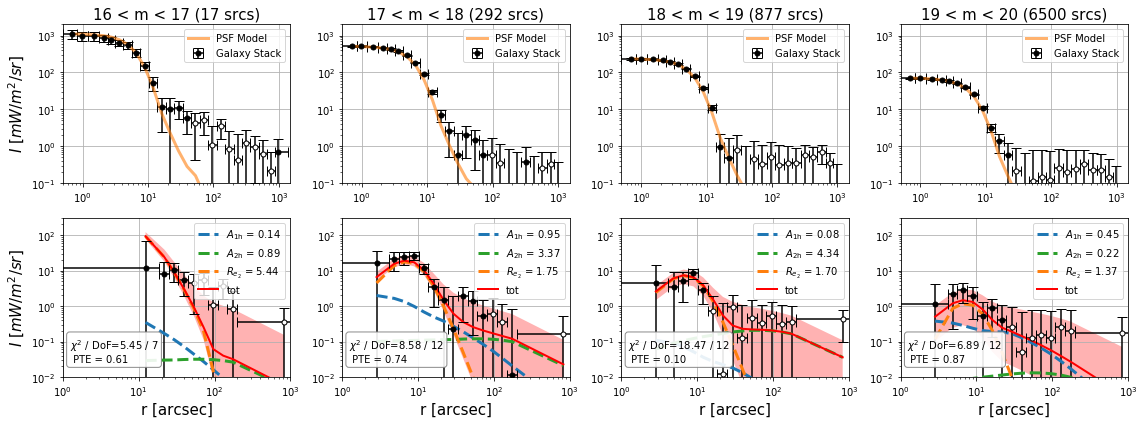

In [8]:
from run_fit import *

inst = 1
filt_order = filt_order_dict[inst]
for ifield in [4,5,6,7,8]:
    plt.close()
    fig, ax = plt.subplots(2, 4, figsize = (16,6))
    for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
        subsub = True if im==0 else False
        stackdat = stacking(inst, ifield, m_min, m_max, filt_order=filt_order,
                    load_from_file=True, BGsub=False, subsub=subsub).stackdat
        param_fit = fit_stacking_mcmc(inst, ifield, im, filt_order,subsub=subsub)
        fitparamdat = get_mcmc_fit_params_3par(inst,im, ifield=ifield,subsub=subsub)
        Re2, A1h, A2h = fitparamdat['Re2'], fitparamdat['A1h'], fitparamdat['A2h'],
        Re2_low, A1h_low, A2h_low \
        = fitparamdat['Re2_low'], fitparamdat['A1h_low'], fitparamdat['A2h_low']
        Re2_high, A1h_high, A2h_high \
        = fitparamdat['Re2_high'], fitparamdat['A1h_high'], fitparamdat['A2h_high']

        Nsrc = param_fit.Nsrc
        r_arr = param_fit.rsubbins
        profd_arr = param_fit.profex_sub
        profd_err = np.sqrt(np.diag(param_fit.covsub))
        
        modelprof = param_fit.get_profexcess_model(Re2=Re2, A1h=A1h, A2h=A2h)
        profex_arr = modelprof['profex_sub']
        prof1h_arr = modelprof['prof1h_sub']
        prof2h_arr = modelprof['prof2h_sub']

        modelprof = param_fit.get_profexcess_model(Re2=Re2_low, A1h=A1h_low, A2h=A2h_low)
        profex_arr_low = modelprof['profex_sub']
        prof1h_arr_low = modelprof['prof1h_sub']
        prof2h_arr_low = modelprof['prof2h_sub']

        modelprof = param_fit.get_profexcess_model(Re2=Re2_high, A1h=A1h_high, A2h=A2h_high)
        profex_arr_high = modelprof['profex_sub']
        prof1h_arr_high = modelprof['prof1h_sub']
        prof2h_arr_high = modelprof['prof2h_sub']

        rbinedges = param_fit.rsubbinedges        
        chi2, pte, dof, chi2_org = param_fit.get_chi2_pte(Npar=3,Re2=Re2, A1h=A1h, A2h=A2h)
        
        ax[1][im].loglog(r_arr, prof1h_arr,'C0--', lw=3, label=r'$A_{\rm 1h}$ = %.2f'%A1h)
        ax[1][im].loglog(r_arr, prof2h_arr,'C2--', lw=3, label=r'$A_{\rm 2h}$ = %.2f'%A2h)
        ax[1][im].loglog(r_arr, profex_arr,'C1--', lw=3, label=r'$R_{e_2}$ = %.2f'%Re2)
        ax[1][im].loglog(r_arr, profex_arr + prof1h_arr + prof2h_arr,'r-', lw=2, label = 'tot')
        
        ax[1][im].fill_between(r_arr, profex_arr_low + prof1h_arr_low + prof2h_arr_low,
                        profex_arr_high + prof1h_arr_high + prof2h_arr_high, facecolor='r', alpha=0.3)

        ax[1][im].text(0.03, 0.10,
                    r'$\chi^2$ / DoF=%.2f / %d'%(chi2,dof) + '\n PTE = %.2f'%(pte),
                    transform=ax[1][im].transAxes,
                    bbox={'boxstyle':'round','alpha':0.9, 'fc':'w','ec':'0.5'}, fontsize=10)
        
        plot_err_log(r_arr, 
                     profd_arr,
                     profd_err,
                     xedges = rbinedges,
                     ax=ax[1][im], color='k')

        plot_err_log(stackdat['rbins'], 
                     stackdat['profcb'],
                     np.sqrt(np.diag(stackdat['cov']['profcb'])),
                     ax=ax[0][im], color='k',label='Galaxy Stack')
        ax[0][im].loglog(stackdat['rbins'],stackdat['PSF']['profcb'],
                      'C1', alpha=0.6, lw=3, label='PSF Model')

        ax[0][im].set_title('%d < m < %d (%d srcs)'%(m_min, m_max, Nsrc),fontsize=15)
        ax[0][im].set_ylim([1e-1,2e3])
        ax[0][im].set_xlim([5e-1,1.5e3])
        ax[0][im].legend(loc=1)
        ax[0][im].grid()
        ax[1][im].set_ylim([1e-2,3e2])
        ax[1][im].set_xlim([1e0,1e3])
        ax[1][im].grid()
        ax[1][im].legend(loc=1)
        ax[1][im].set_xlabel('r [arcsec]',fontsize=15)
    ax[0][0].set_ylabel(r'$I$ [$mW/m^2/sr$]',fontsize=15)
    ax[1][0].set_ylabel(r'$I$ [$mW/m^2/sr$]',fontsize=15)
#     fig.suptitle(fieldnamedict[ifield], fontsize=16)

    plt.tight_layout()
    plt.savefig('plots/TM%d/profile_best_%s_3par.png'%(inst,param_fit.field), dpi = 150)

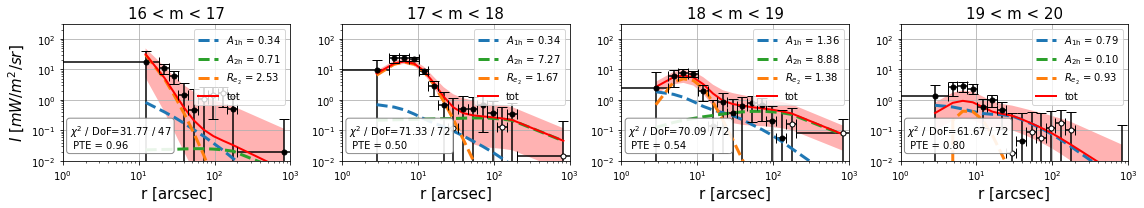

In [36]:
from run_fit import *

inst = 1
filt_order = filt_order_dict[inst]
fig, ax = plt.subplots(1, 4, figsize = (16,3))
for im in range(4):
    subsub = True if im==0 else False
    fitparamdat = get_mcmc_fit_params_3par(inst,im, subsub=subsub)
    Re2, A1h, A2h = fitparamdat['Re2'], fitparamdat['A1h'], fitparamdat['A2h'],
    Re2_low, A1h_low, A2h_low \
    = fitparamdat['Re2_low'], fitparamdat['A1h_low'], fitparamdat['A2h_low']
    Re2_high, A1h_high, A2h_high \
    = fitparamdat['Re2_high'], fitparamdat['A1h_high'], fitparamdat['A2h_high']

    param_fit = joint_fit_mcmc(inst,im,filt_order, subsub=subsub)
    chi2, pte, dof, chi2_org = param_fit.get_chi2_pte(Npar=3,Re2=Re2, A1h=A1h, A2h=A2h)

    profd_arr, profd_err = 0, 0
    profex_arr, profex_arr_low, profex_arr_high = 0, 0, 0
    prof1h_arr, prof1h_arr_low, prof1h_arr_high = 0, 0, 0
    prof2h_arr, prof2h_arr_low, prof2h_arr_high = 0, 0, 0
    for ifield in [4,5,6,7,8]:
        param_fit = fit_stacking_mcmc(inst, ifield, im, filt_order, subsub=subsub)

        profd_arri = param_fit.profex_sub
        profd_erri = np.sqrt(np.diag(param_fit.covsub))
        profd_arr += profd_arri / profd_erri**2
        profd_err += 1 / profd_erri**2

        modelprof = param_fit.get_profexcess_model(Re2=Re2, A1h=A1h, A2h=A2h)
        profex_arri = modelprof['profex_sub']
        prof1h_arri = modelprof['prof1h_sub']
        prof2h_arri = modelprof['prof2h_sub']
        profex_arr += profex_arri
        prof1h_arr += prof1h_arri
        prof2h_arr += prof2h_arri
        
        modelprof = param_fit.get_profexcess_model(Re2=Re2_low, A1h=A1h_low, A2h=A2h_low)
        profex_arri = modelprof['profex_sub']
        prof1h_arri = modelprof['prof1h_sub']
        prof2h_arri = modelprof['prof2h_sub']
        profex_arr_low += profex_arri
        prof1h_arr_low += prof1h_arri
        prof2h_arr_low += prof2h_arri

        modelprof = param_fit.get_profexcess_model(Re2=Re2_high, A1h=A1h_high, A2h=A2h_high)
        profex_arri = modelprof['profex_sub']
        prof1h_arri = modelprof['prof1h_sub']
        prof2h_arri = modelprof['prof2h_sub']
        profex_arr_high += profex_arri
        prof1h_arr_high += prof1h_arri
        prof2h_arr_high += prof2h_arri

    profex_arr /= 5
    profex_arr_low /= 5
    profex_arr_high /= 5
    prof1h_arr /= 5
    prof1h_arr_low /= 5
    prof1h_arr_high /= 5
    prof2h_arr /= 5
    prof2h_arr_low /= 5
    prof2h_arr_high /= 5
    profd_arr /= profd_err
    profd_err = np.sqrt(1 / profd_err)
    
    r_arr = param_fit.rsubbins
    rbinedges = param_fit.rsubbinedges
    
    ax[im].loglog(r_arr, prof1h_arr,'C0--', lw=3, label=r'$A_{\rm 1h}$ = %.2f'%A1h)
    ax[im].loglog(r_arr, prof2h_arr,'C2--', lw=3, label=r'$A_{\rm 2h}$ = %.2f'%A2h)
    ax[im].loglog(r_arr, profex_arr,'C1--', lw=3, label=r'$R_{e_2}$ = %.2f'%Re2)
    ax[im].loglog(r_arr, profex_arr + prof1h_arr + prof2h_arr,'r-', lw=2, label = 'tot')
    ax[im].fill_between(r_arr, profex_arr_low + prof1h_arr_low + prof2h_arr_low,
                       profex_arr_high + prof1h_arr_high + prof2h_arr_high, facecolor='r', alpha=0.3)
    ax[im].text(0.03, 0.10,
                r'$\chi^2$ / DoF=%.2f / %d'%(chi2,dof) + '\n PTE = %.2f'%(pte),
                transform=ax[im].transAxes,
                bbox={'boxstyle':'round','alpha':0.9, 'fc':'w','ec':'0.5'}, fontsize=10)

    plot_err_log(r_arr, 
                 profd_arr,
                 profd_err,
                 xedges = rbinedges,
                 ax=ax[im], color='k')

    ax[im].set_title('%d < m < %d'%(param_fit.m_min, param_fit.m_max),fontsize=15)
    ax[im].set_ylim([1e-2,3e2])
    ax[im].set_xlim([1e0,1e3])
    ax[im].grid()
    ax[im].set_xlabel('r [arcsec]',fontsize=15)
    ax[im].legend(loc=1)
ax[0].set_ylabel(r'$I$ [$mW/m^2/sr$]',fontsize=15)

plt.tight_layout()
plt.savefig('plots/TM%d/profile_best_joint_3par.png'%inst, dpi = 200, bbox_inches='tight')

### marginalized params

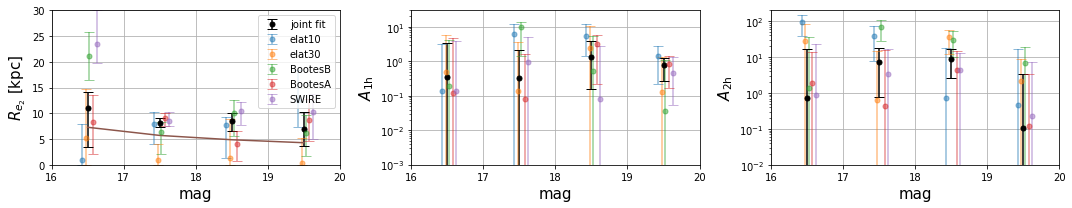

In [37]:
from run_fit import *

inst = 1
fig, ax = plt.subplots(1, 3, figsize = (15,3))
for ifield in [None,4,5,6,7,8]:
    xoff = 0 if ifield is None else (ifield-5.5)*0.05
    Re2_W19_arr = np.zeros(4)
    Re2_arr = np.zeros(4)
    A1h_arr = np.zeros(4)
    A2h_arr = np.zeros(4)
    Re2_low_arr = np.zeros(4)
    A1h_low_arr = np.zeros(4)
    A2h_low_arr = np.zeros(4)
    Re2_high_arr = np.zeros(4)
    A1h_high_arr = np.zeros(4)
    A2h_high_arr = np.zeros(4)
    arcsec2Mpc_arr = np.zeros(4)
    for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
        subsub = True if im==0 else False
        R200 = gal_profile_model().Wang19_profile(0,im)['params']['R200']
        xe2_W19 = gal_profile_model().Wang19_profile(0,3)['params']['sersic2'][2]
        Re2_W19 = R200 * xe2_W19
        Re2_W19_arr[im] = Re2_W19

        fitparamdat = get_mcmc_fit_params_3par(inst,im, ifield=ifield, subsub=subsub)
        Re2_arr[im] = fitparamdat['Re2']
        A1h_arr[im] = fitparamdat['A1h']
        A2h_arr[im] = fitparamdat['A2h']
        Re2_low_arr[im] = fitparamdat['Re2_low']
        A1h_low_arr[im] = fitparamdat['A1h_low']
        A2h_low_arr[im] = fitparamdat['A2h_low']
        Re2_high_arr[im] = fitparamdat['Re2_high']
        A1h_high_arr[im] = fitparamdat['A1h_high']
        A2h_high_arr[im] = fitparamdat['A2h_high']
        
        arcsec2Mpc_arr[im] \
        = gal_profile_model().Wang19_profile(0,im)['params']['R200_Mpc'] / R200 *1000
    
    Re2_W19_arr *= arcsec2Mpc_arr
    Re2_arr *= arcsec2Mpc_arr
    Re2_low_arr *= arcsec2Mpc_arr
    Re2_high_arr *= arcsec2Mpc_arr

    m_arr = (np.array(magbindict['m_min']) + np.array(magbindict['m_max'])) / 2

    if ifield is None:
        ax[0].errorbar(m_arr+xoff, Re2_arr, [Re2_arr - Re2_low_arr, Re2_high_arr - Re2_arr],
                      fmt='.', capsize=5, markersize=10, c='k', label = 'joint fit')
        ax[1].errorbar(m_arr+xoff, A1h_arr, [A1h_arr - A1h_low_arr, A1h_high_arr - A1h_arr],
                      fmt='.', capsize=5, markersize=10, c='k', label = 'joint fit')
        ax[2].errorbar(m_arr+xoff, A2h_arr, [A2h_arr - A2h_low_arr, A2h_high_arr - A2h_arr],
                      fmt='.', capsize=5, markersize=10, c='k', label = 'joint fit')
    else:
        ax[0].errorbar(m_arr+xoff, Re2_arr, [Re2_arr - Re2_low_arr, Re2_high_arr - Re2_arr],
                      fmt='.', capsize=5, markersize=10, alpha = 0.5, label = fieldnamedict[ifield])
        ax[1].errorbar(m_arr+xoff, A1h_arr, [A1h_arr - A1h_low_arr, A1h_high_arr - A1h_arr],
                      fmt='.', capsize=5, markersize=10, label = fieldnamedict[ifield], alpha = 0.5)
        ax[2].errorbar(m_arr+xoff, A2h_arr, [A2h_arr - A2h_low_arr, A2h_high_arr - A2h_arr],
                      fmt='.', capsize=5, markersize=10, label = fieldnamedict[ifield], alpha = 0.5)

ax[0].plot(m_arr, Re2_W19_arr)
ax[0].legend(loc=1)
ax[0].set_ylim([0,30])
ax[1].set_ylim([1e-3,3e1])
ax[2].set_ylim([1e-2,2e2])
ax[0].set_xlabel('mag', fontsize=15)
ax[1].set_xlabel('mag', fontsize=15)
ax[2].set_xlabel('mag', fontsize=15)
ax[0].set_ylabel(r"$R_{e_2}$ [kpc]", fontsize=15)
ax[1].set_ylabel(r"$A_{\rm 1h}$", fontsize=15)
ax[2].set_ylabel(r"$A_{\rm 2h}$", fontsize=15)
ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[0].set_xticks([16,17,18,19,20])
ax[1].set_xticks([16,17,18,19,20])
ax[2].set_xticks([16,17,18,19,20])
ax[0].grid()
ax[1].grid()
ax[2].grid()

plt.tight_layout()
plt.savefig('plots/TM%d/params_best_3par.png'%inst, dpi = 150)

***
# 2 params

### corner

In [38]:
from run_fit import *
import corner
from PIL import Image

inst = 1

for ifield in [0,4,5,6,7,8]:
    if ifield==0:
        truths_arr = []
    for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
        
        R200 = gal_profile_model().Wang19_profile(0,im)['params']['R200']
        xe2_W19 = gal_profile_model().Wang19_profile(0,3)['params']['sersic2'][2]
        Re2_W19 = R200 * xe2_W19
        
        if ifield==0:
            savedir = mypaths['alldat'] + 'TM' + str(inst) + '/'
            savename = 'mcmc_2par_joint' + \
            '_m' + str(m_min) + '_' + str(m_max) + '.npy'
        else:
            savedir = mypaths['alldat'] + 'TM' + str(inst) + '/'
            savename = 'mcmc_2par_' + fieldnamedict[ifield] + \
            '_m' + str(m_min) + '_' + str(m_max) + '.npy'

        if subsub:
            savename = savename[:-4] + '_sub.npy'

        samples = np.load(savedir + savename)
        steps, nwalkers, nparams = samples.shape

        flatsamps = samples.copy()
        flatsamps[:,:,0] = flatsamps[:,:,0] * R200
        flatsamps = flatsamps[150:,:,:].reshape((-1,2))

        bins0 = np.linspace(np.min(flatsamps[:,0]), np.max(flatsamps[:,0]), 20)
        bins1 = np.linspace(np.min(flatsamps[:,1]), np.max(flatsamps[:,1]), 20)
        
        if ifield==0:
            truths_arr.append(np.median(flatsamps, axis=0))

        levels= 1.0 - np.exp(-0.5 * np.arange(1, 2.1, 1) ** 2)
        figure = corner.corner(flatsamps, levels = levels,fill_contours=True,plot_datapoints=False,
                               bins=[bins0, bins1],label_kwargs={'fontsize':'xx-large'},
                               range=[(0,5),(0,200)],
                               title_kwargs={'fontsize':'x-large'},
                               show_titles=True,labels=["$R_{e_2}$",r"$A_{\rm 2h}$"],
                               truths=[Re2_W19,1,1])
        if ifield==0:
            plt.savefig('plots/TM%d/mcmc_joint_m%d_%d.png'\
                        %(inst,m_min, m_max), dpi=150)
        else:
            plt.savefig('plots/TM%d/mcmc_%s_m%d_%d.png'\
                        %(inst,fieldnamedict[ifield], m_min, m_max), dpi=150)

        plt.close()
        

#combine four mag plots into one plot
for ifield in [0,4,5,6,7,8]:
    result = Image.new("RGB", (3200,800))    
    for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
        fieldname = 'joint' if ifield==0 else fieldnamedict[ifield]
        fname = 'plots/TM%d/mcmc_%s_m%d_%d.png'\
                        %(inst, fieldname, m_min, m_max)
        path = os.path.expanduser(fname)
        img = Image.open(path)
        img.thumbnail((800, 800), Image.ANTIALIAS)
        x = im * 800
        y = 0
        w, h = img.size
        result.paste(img, (x, y, x + w, y + h))
        os.remove(fname)
    
    result.save(os.path.expanduser('plots/TM%d/mcmc_%s_2par.png'%(inst,fieldname)))

In [39]:
from run_fit import *
import corner
from PIL import Image

inst = 1

for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
    figure1, ax = plt.subplots(2,2,figsize=(8,8))
    figure2, ax = plt.subplots(2,2,figsize=(8,8))

    R200 = gal_profile_model().Wang19_profile(0,im)['params']['R200']
    xe2_W19 = gal_profile_model().Wang19_profile(0,3)['params']['sersic2'][2]
    Re2_W19 = R200 * xe2_W19
    for ifield in [0,4,5,6,7,8]:
        if ifield==0:
            savedir = mypaths['alldat'] + 'TM' + str(inst) + '/'
            savename = 'mcmc_2par_joint' + \
            '_m' + str(m_min) + '_' + str(m_max) + '.npy'
            c = 'k'
        else:
            savedir = mypaths['alldat'] + 'TM' + str(inst) + '/'
            savename = 'mcmc_2par_' + fieldnamedict[ifield] + \
            '_m' + str(m_min) + '_' + str(m_max) + '.npy'
            c = 'C' + str(ifield-4)

        if subsub:
            savename = savename[:-4] + '_sub.npy'

        samples = np.load(savedir + savename)
        steps, nwalkers, nparams = samples.shape

        flatsamps = samples.copy()
        flatsamps[:,:,0] = flatsamps[:,:,0] * R200
        flatsamps = flatsamps[150:,:,:].reshape((-1,2))

        bins0 = np.linspace(np.min(flatsamps[:,0]), np.max(flatsamps[:,0]), 20)
        bins1 = np.linspace(np.min(flatsamps[:,1]), np.max(flatsamps[:,1]), 20)
        
        levels= 1.0 - np.exp(-0.5 * np.array([1]) ** 2)
        figure = corner.corner(flatsamps, levels = levels,fill_contours=False,color=c,
                               plot_datapoints=False,
                               bins=[bins0, bins1],label_kwargs={'fontsize':'xx-large'},
                               range=[(0,5),(0,200)],
                               title_kwargs={'fontsize':'x-large'},
                               show_titles=True,labels=["$R_{e_2}$",r"$A_{\rm 2h}$"],
                               fig=figure1)

        levels= 1.0 - np.exp(-0.5 * np.array([2]) ** 2)
        figure = corner.corner(flatsamps, levels = levels,fill_contours=False,color=c,
                               plot_datapoints=False,
                               bins=[bins0, bins1],label_kwargs={'fontsize':'xx-large'},
                               range=[(0,5),(0,200)],
                               title_kwargs={'fontsize':'x-large'},
                               show_titles=True,labels=["$R_{e_2}$", r"$A_{\rm 2h}$"],
                               fig=figure2)
        
    figure1.savefig('plots/TM%d/mcmc_m%d_%d_1sig.png'\
                %(inst, m_min, m_max), dpi=150)
    figure2.savefig('plots/TM%d/mcmc_m%d_%d_2sig.png'\
                %(inst, m_min, m_max), dpi=150)
    
    plt.close(figure1)
    plt.close(figure2)
#combine four mag plots into one plot
result = Image.new("RGB", (3200,800))    
for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
    fname = 'plots/TM%d/mcmc_m%d_%d_1sig.png'\
                    %(inst, m_min, m_max)
    path = os.path.expanduser(fname)
    img = Image.open(path)
    img.thumbnail((800, 800), Image.ANTIALIAS)
    x = im * 800
    y = 0
    w, h = img.size
    result.paste(img, (x, y, x + w, y + h))
    os.remove(fname)
    
    result.save(os.path.expanduser('plots/TM%d/mcmc_1sig_2par.png'%(inst)))

result = Image.new("RGB", (3200,800))    
for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):    
    fname = 'plots/TM%d/mcmc_m%d_%d_2sig.png'\
                    %(inst, m_min, m_max)
    path = os.path.expanduser(fname)
    img = Image.open(path)
    img.thumbnail((800, 800), Image.ANTIALIAS)
    x = im * 800
    y = 0
    w, h = img.size
    result.paste(img, (x, y, x + w, y + h))
    os.remove(fname)
    
    result.save(os.path.expanduser('plots/TM%d/mcmc_2sig_2par.png'%(inst)))

### 1D profile

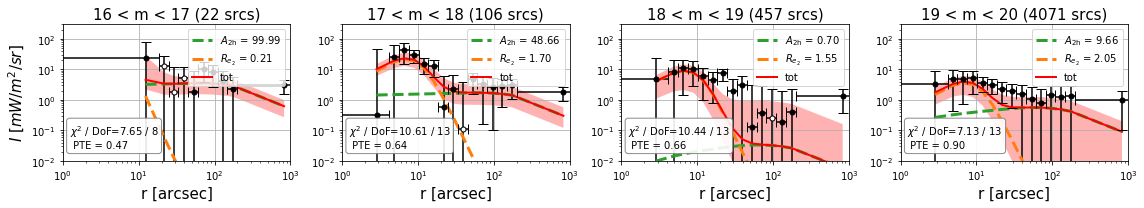

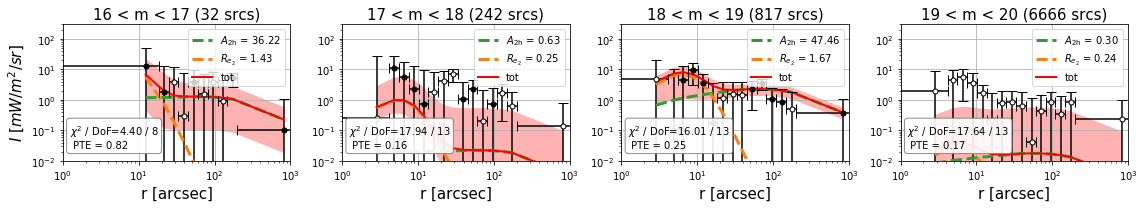

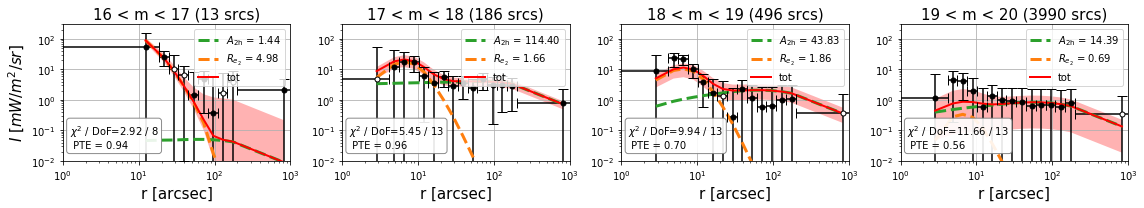

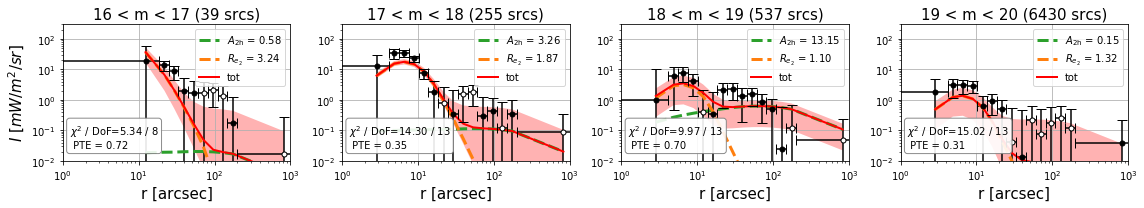

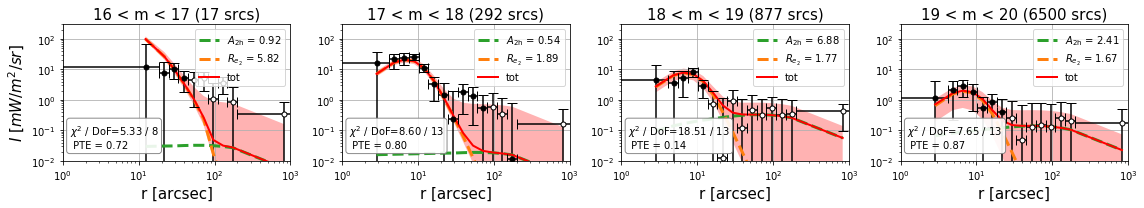

In [8]:
from run_fit import *

inst = 1
filt_order = filt_order_dict[inst]
for ifield in [4,5,6,7,8]:
    fig, ax = plt.subplots(1, 4, figsize = (16,3))
    for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
        subsub = True if im==0 else False
        param_fit = fit_stacking_mcmc(inst, ifield, im, filt_order, subsub=subsub)
        fitparamdat = get_mcmc_fit_params_2par(inst,im, ifield=ifield, subsub=subsub)
        Re2, A2h = fitparamdat['Re2'], fitparamdat['A2h'],
        Re2_low, A2h_low = fitparamdat['Re2_low'], fitparamdat['A2h_low']
        Re2_high, A2h_high = fitparamdat['Re2_high'], fitparamdat['A2h_high']

        Nsrc = param_fit.Nsrc
        r_arr = param_fit.rsubbins
        profd_arr = param_fit.profex_sub
        profd_err = np.sqrt(np.diag(param_fit.covsub))
        
        modelprof = param_fit.get_profexcess_model(Re2=Re2, A1h=0, A2h=A2h)
        profex_arr = modelprof['profex_sub']
        prof2h_arr = modelprof['prof2h_sub']
        
        modelprof = param_fit.get_profexcess_model(Re2=Re2_low, A1h=0, A2h=A2h_low)
        profex_arr_low = modelprof['profex_sub']
        prof2h_arr_low = modelprof['prof2h_sub']
        
        modelprof = param_fit.get_profexcess_model(Re2=Re2_high, A1h=0, A2h=A2h_high)
        profex_arr_high = modelprof['profex_sub']
        prof2h_arr_high = modelprof['prof2h_sub']
        
        rbinedges = param_fit.rsubbinedges
        chi2, pte, dof, chi2_org = param_fit.get_chi2_pte(Npar=2,Re2=Re2, A1h=0, A2h=A2h)
        ax[im].loglog(r_arr, prof2h_arr,'C2--', lw=3, label=r'$A_{\rm 2h}$ = %.2f'%A2h)
        ax[im].loglog(r_arr, profex_arr,'C1--', lw=3, label=r'$R_{e_2}$ = %.2f'%Re2)
        ax[im].loglog(r_arr, profex_arr + prof2h_arr,'r-', lw=2, label = 'tot')
        ax[im].fill_between(r_arr, profex_arr_low + prof2h_arr_low,
                        profex_arr_high + prof2h_arr_high, facecolor='r', alpha=0.3)

        ax[im].text(0.03, 0.10,
                    r'$\chi^2$ / DoF=%.2f / %d'%(chi2,dof) + '\n PTE = %.2f'%(pte),
                    transform=ax[im].transAxes,
                    bbox={'boxstyle':'round','alpha':0.9, 'fc':'w','ec':'0.5'}, fontsize=10)
 
        plot_err_log(r_arr, 
                     profd_arr,
                     profd_err,
                     xedges = rbinedges,
                     ax=ax[im], color='k')


        ax[im].set_title('%d < m < %d (%d srcs)'%(m_min, m_max, Nsrc), fontsize=15)
        ax[im].set_ylim([1e-2,3e2])
        ax[im].set_xlim([1e0,1e3])
        ax[im].grid()
        ax[im].legend(loc=1)
        ax[im].set_xlabel('r [arcsec]',fontsize=15)
    ax[0].set_ylabel(r'$I$ [$mW/m^2/sr$]',fontsize=15)
#     fig.suptitle(fieldnamedict[ifield], fontsize=16)

    plt.tight_layout()
    plt.savefig('plots/TM%d/profile_best_%s_2par.png'%(inst,param_fit.field), dpi = 150)

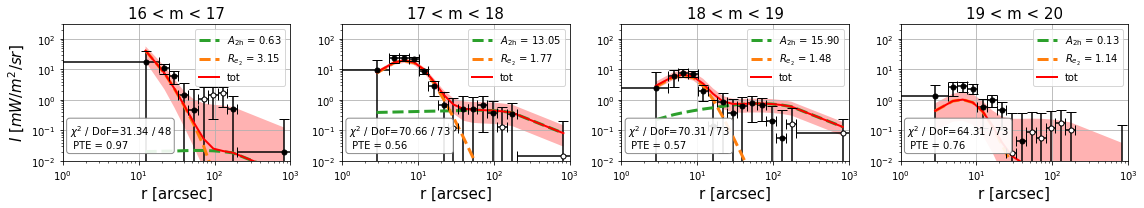

In [28]:
from run_fit import *

inst = 1
filt_order = filt_order_dict[inst]
fig, ax = plt.subplots(1, 4, figsize = (16,3))
for im in range(4):
    subsub = True if im==0 else False
    fitparamdat = get_mcmc_fit_params_2par(inst,im, subsub=subsub)
    Re2, A2h = fitparamdat['Re2'], fitparamdat['A2h'],
    Re2_low,  A2h_low = fitparamdat['Re2_low'], fitparamdat['A2h_low']
    Re2_high, A2h_high = fitparamdat['Re2_high'], fitparamdat['A2h_high']

    param_fit = joint_fit_mcmc(inst,im,filt_order, subsub=subsub)
    chi2, pte, dof, chi2_org = param_fit.get_chi2_pte(Npar=2,Re2=Re2, A1h=0, A2h=A2h)
    
    profd_arr, profd_err = 0, 0
    profex_arr, profex_arr_low, profex_arr_high = 0, 0, 0
    prof2h_arr, prof2h_arr_low, prof2h_arr_high = 0, 0, 0
    for ifield in [4,5,6,7,8]:
        param_fit = fit_stacking_mcmc(inst, ifield, im, filt_order, subsub=subsub)

        profd_arri = param_fit.profex_sub
        profd_erri = np.sqrt(np.diag(param_fit.covsub))
        profd_arr += profd_arri / profd_erri**2
        profd_err += 1 / profd_erri**2

        modelprof = param_fit.get_profexcess_model(Re2=Re2, A1h=0, A2h=A2h)
        profex_arri = modelprof['profex_sub']
        prof2h_arri = modelprof['prof2h_sub']
        profex_arr += profex_arri
        prof2h_arr += prof2h_arri
        
        modelprof = param_fit.get_profexcess_model(Re2=Re2_low, A1h=0, A2h=A2h_low)
        profex_arri = modelprof['profex_sub']
        prof2h_arri = modelprof['prof2h_sub']
        profex_arr_low += profex_arri
        prof2h_arr_low += prof2h_arri

        modelprof = param_fit.get_profexcess_model(Re2=Re2_high, A1h=0, A2h=A2h_high)
        profex_arri = modelprof['profex_sub']
        prof2h_arri = modelprof['prof2h_sub']
        profex_arr_high += profex_arri
        prof2h_arr_high += prof2h_arri

    profex_arr /= 5
    profex_arr_low /= 5
    profex_arr_high /= 5
    prof2h_arr /= 5
    prof2h_arr_low /= 5
    prof2h_arr_high /= 5
    profd_arr /= profd_err
    profd_err = np.sqrt(1 / profd_err)
    
    r_arr = param_fit.rsubbins
    rbinedges = param_fit.rsubbinedges

    ax[im].loglog(r_arr, prof2h_arr,'C2--', lw=3, label=r'$A_{\rm 2h}$ = %.2f'%A2h)
    ax[im].loglog(r_arr, profex_arr,'C1--', lw=3, label=r'$R_{e_2}$ = %.2f'%Re2)
    ax[im].loglog(r_arr, profex_arr + prof2h_arr,'r-', lw=2, label = 'tot')
    ax[im].fill_between(r_arr, profex_arr_low + prof2h_arr_low,
                       profex_arr_high + prof2h_arr_high, lw=2, facecolor='r', alpha=0.3)
    ax[im].text(0.03, 0.10,
                r'$\chi^2$ / DoF=%.2f / %d'%(chi2,dof) + '\n PTE = %.2f'%(pte),
                transform=ax[im].transAxes,
                bbox={'boxstyle':'round','alpha':0.9, 'fc':'w','ec':'0.5'}, fontsize=10)

    plot_err_log(r_arr, 
                 profd_arr,
                 profd_err,
                 xedges = rbinedges,
                 ax=ax[im], color='k')

    ax[im].set_title('%d < m < %d'%(param_fit.m_min, param_fit.m_max),fontsize=15)
    ax[im].set_ylim([1e-2,3e2])
    ax[im].set_xlim([1e0,1e3])
    ax[im].grid()
    ax[im].set_xlabel('r [arcsec]',fontsize=15)
    ax[im].legend(loc=1)
ax[0].set_ylabel(r'$I$ [$mW/m^2/sr$]',fontsize=15)

plt.tight_layout()
plt.savefig('plots/TM%d/profile_best_joint_2par.png'%inst, dpi = 200, bbox_inches='tight')

### marginalized params

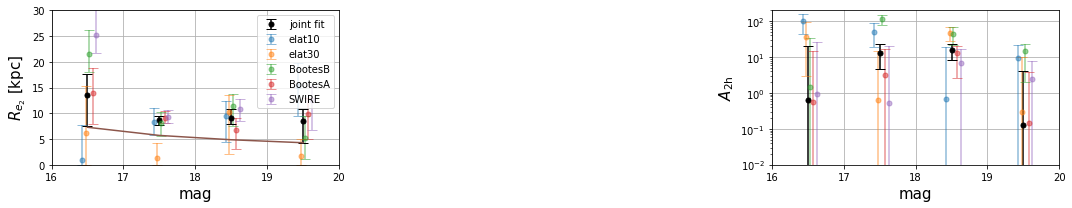

In [40]:
from run_fit import *

inst = 1
fig, ax = plt.subplots(1, 3, figsize = (15,3))
for ifield in [None,4,5,6,7,8]:
    xoff = 0 if ifield is None else (ifield-5.5)*0.05
    Re2_W19_arr = np.zeros(4)
    Re2_arr = np.zeros(4)
    A2h_arr = np.zeros(4)
    Re2_low_arr = np.zeros(4)
    A2h_low_arr = np.zeros(4)
    Re2_high_arr = np.zeros(4)
    A2h_high_arr = np.zeros(4)
    arcsec2kpc_arr = np.zeros(4)
    for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
        subsub = True if im==0 else False
        R200 = gal_profile_model().Wang19_profile(0,im)['params']['R200']
        xe2_W19 = gal_profile_model().Wang19_profile(0,3)['params']['sersic2'][2]
        Re2_W19 = R200 * xe2_W19
        Re2_W19_arr[im] = Re2_W19
        
        fitparamdat = get_mcmc_fit_params_2par(inst,im, ifield=ifield, subsub=subsub)
        Re2_arr[im] = fitparamdat['Re2']
        A2h_arr[im] = fitparamdat['A2h']
        Re2_low_arr[im] = fitparamdat['Re2_low']
        A2h_low_arr[im] = fitparamdat['A2h_low']
        Re2_high_arr[im] = fitparamdat['Re2_high']
        A2h_high_arr[im] = fitparamdat['A2h_high']

        arcsec2Mpc_arr[im] \
        = gal_profile_model().Wang19_profile(0,im)['params']['R200_Mpc'] / R200 *1000
    
    Re2_W19_arr *= arcsec2Mpc_arr
    Re2_arr *= arcsec2Mpc_arr
    Re2_low_arr *= arcsec2Mpc_arr
    Re2_high_arr *= arcsec2Mpc_arr
    
    m_arr = (np.array(magbindict['m_min']) + np.array(magbindict['m_max'])) / 2

    if ifield is None:
        ax[0].errorbar(m_arr+xoff, Re2_arr, [Re2_arr - Re2_low_arr, Re2_high_arr - Re2_arr],
                      fmt='.', capsize=5, markersize=10, c='k', label = 'joint fit')
        ax[2].errorbar(m_arr+xoff, A2h_arr, [A2h_arr - A2h_low_arr, A2h_high_arr - A2h_arr],
                      fmt='.', capsize=5, markersize=10, c='k', label = 'joint fit')
    else:
        ax[0].errorbar(m_arr+xoff, Re2_arr, [Re2_arr - Re2_low_arr, Re2_high_arr - Re2_arr],
                      fmt='.', capsize=5, markersize=10, alpha = 0.5, label = fieldnamedict[ifield])
        ax[2].errorbar(m_arr+xoff, A2h_arr, [A2h_arr - A2h_low_arr, A2h_high_arr - A2h_arr],
                      fmt='.', capsize=5, markersize=10, label = fieldnamedict[ifield], alpha = 0.5)

ax[0].plot(m_arr, Re2_W19_arr)
ax[0].set_ylim([0,30])
ax[2].set_ylim([1e-2,2e2])
ax[0].set_xlabel('mag', fontsize=15)
ax[2].set_xlabel('mag', fontsize=15)
ax[0].set_ylabel(r"$R_{e_2}$ [kpc]", fontsize=15)
ax[2].set_ylabel(r"$A_{\rm 2h}$", fontsize=15)
ax[2].set_yscale('log')
ax[0].set_xticks([16,17,18,19,20])
ax[2].set_xticks([16,17,18,19,20])
ax[0].grid()
ax[2].grid()
ax[1].axis('off')
ax[0].legend(loc=1)

plt.tight_layout()
plt.savefig('plots/TM%d/params_best_2par.png'%inst, dpi = 150)

# Look at the chains

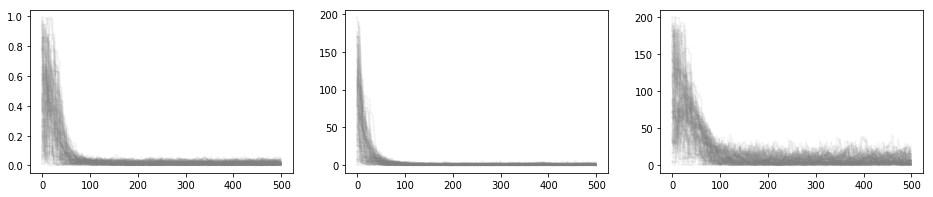

In [10]:
inst = 1
ifield = 5
im = 3
Npar = 3
subsub = False

R200 = gal_profile_model().Wang19_profile(0,im)['params']['R200']

if ifield in [4,5,6,7,8]:
    savename = 'mcmc_'+ str(Npar) + 'par_' + fieldnamedict[ifield] + \
    '_m' + str(magbindict['m_min'][im]) + '_' + str(magbindict['m_max'][im]) + '.npy'
elif ifield is None:
    savename = 'mcmc_3par_joint' + \
    '_m' + str(magbindict['m_min'][im]) + '_' + str(magbindict['m_max'][im]) + '.npy'

if subsub:
    savename = savename[:-4] + '_sub.npy'

chaindir = mypaths['alldat'] + 'TM' + str(inst) + '/'
samples = np.load(chaindir + savename)
flatsamps = samples.copy()

fig, ax = plt.subplots(1, 3, figsize = (16,3))
for i in range(flatsamps.shape[1]):
    ax[0].plot(flatsamps[:,i,0], c='grey', alpha=0.1)
    if Npar==3:
        ax[1].plot(flatsamps[:,i,1], c='grey', alpha=0.1)
        ax[2].plot(flatsamps[:,i,2], c='grey', alpha=0.1)
    else:
        ax[2].plot(flatsamps[:,i,1], c='grey', alpha=0.1)
        ax[1].axis('off')

# Try other MCMC sampling

In [4]:
# from run_fit import *

# sampler0 = fit_stacking_mcmc(1,6,0,3).run_mcmc(nwalkers=50, steps=150, 
#                                                return_sampler=True, save_chain=False,
#                                              moves=[(emcee.moves.StretchMove(), 2)])
# sampler1 = fit_stacking_mcmc(1,6,0,3).run_mcmc(nwalkers=50, steps=150, 
#                                                return_sampler=True, save_chain=False,
#                                              moves=[(emcee.moves.StretchMove(), 10)])
# sampler = fit_stacking_mcmc(1,6,0,3).run_mcmc(nwalkers=100, steps=500, return_sampler=True,
#                                               save_chain=False,moves=[(emcee.moves.DEMove())])
# chain = sampler.get_chain()
# np.save('chain_DEMove',chain)

# sampler = fit_stacking_mcmc(1,6,0,3).run_mcmc(nwalkers=100, steps=500, return_sampler=True,
#                                                save_chain=False,moves=[(emcee.moves.DESnookerMove())])
# chain = sampler.get_chain()
# np.save('chain_DESnookerMove',chain)

# sampler = fit_stacking_mcmc(1,6,0,3).run_mcmc(nwalkers=100, steps=500, return_sampler=True,
#                                                save_chain=False,moves=[(emcee.moves.KDEMove())])
# chain = sampler.get_chain()
# np.save('chain_KDEMove',chain)

# sampler = fit_stacking_mcmc(1,6,0,3).run_mcmc(nwalkers=100, steps=500, return_sampler=True,
#                                                save_chain=False,moves=[(emcee.moves.WalkMove())])
# chain = sampler.get_chain()
# np.save('chain_WalkMove',chain)

# SVD for Inv Cov

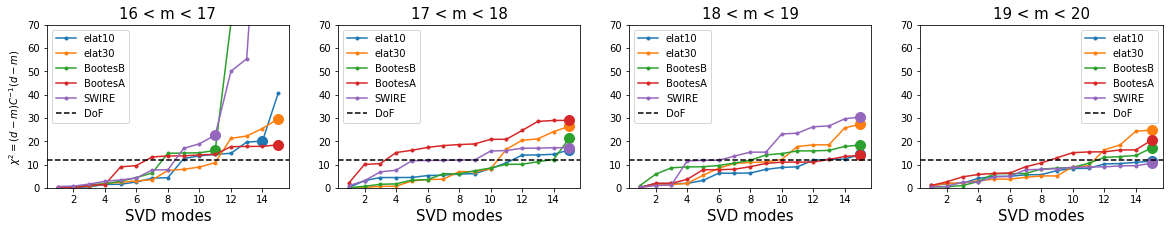

In [155]:
from stack import *
from run_fit import *
inst = 1
filt_order = 3

fig, ax = plt.subplots(1, 4, figsize = (20,3))
for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
    R200 = gal_profile_model().Wang19_profile(0,im)['params']['R200']
    xe2_W19 = gal_profile_model().Wang19_profile(0,3)['params']['sersic2'][2]
    Re2_W19 = R200 * xe2_W19
    for ifield in [4,5,6,7,8]:        
        param_fit = fit_stacking_mcmc(inst, ifield, im, filt_order)
        modelprof = param_fit.get_profexcess_model(Re2=Re2_W19, A1h=1, A2h=1)
        M = modelprof['profex_sub'] + modelprof['prof1h_sub'] + modelprof['prof2h_sub']
        D = param_fit.profex_sub
        
        Cov =param_fit.covsub
        Covi, Nmode = param_fit.covsub_inv, param_fit.covsub_inv_Nmode
        
        ax[im].plot([Nmode],[param_fit.get_chi2(Re2=Re2_W19, A1h=1, A2h=1)],
                   'o',C='C'+str(ifield-4),markersize=10)
        # SVD
        U, s, VT = np.linalg.svd(Cov)
        V = VT.T
        UT = U.T
        S = np.diag(s)
        Sinv  = np.diag(1/s)
        chi2_arr = []
        for Nmode in np.arange(len(s))+1:
            Cov_svd = U[:,:Nmode]@S[:Nmode,:Nmode]@VT[:Nmode,:]
            Covi_svd = V[:,:Nmode]@Sinv[:Nmode,:Nmode]@UT[:Nmode,:]

            chi2_mat_svd = Covi_svd * ((D-M)[:,np.newaxis] @ (D-M)[:,np.newaxis].T)
            chi2_arr.append(np.sum(chi2_mat_svd))   
        
        ax[im].plot(np.arange(len(s))+1, chi2_arr,'.-',label=param_fit.field,C='C'+str(ifield-4))
        
    ax[im].set_title('%d < m < %d'%(m_min, m_max),fontsize=15)
    ax[0].set_ylabel(r'$\chi^2 = (d-m)C^{-1}(d-m)$',fontsize=10)
    ax[im].set_xlabel('SVD modes',fontsize=15)
    ax[im].axhline(len(s)-3,c='k',ls='--',label='DoF')
    ax[im].set_ylim([0,70])
    ax[im].legend()

plt.savefig('/Users/ytcheng/Desktop/cov_svd.png', dpi = 150,bbox_inches='tight')

# Modify Cov Gal Inner parts

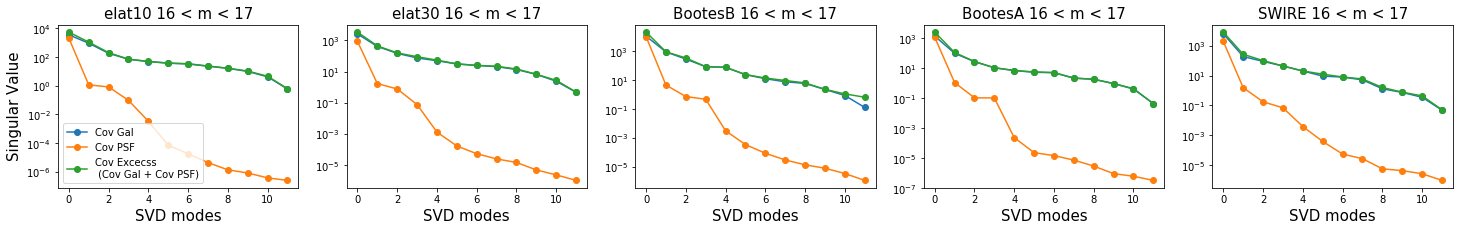

In [3]:
from stack import *

inst = 1
im = 0
m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]
fig, ax = plt.subplots(1, 5, figsize = (25,3))
for i,ifield in enumerate([4,5,6,7,8]):
    stackdat = stacking(1,ifield,m_min, m_max,filt_order=3,
                        load_from_file=True, BGsub=False,subsub=True).stackdat
    covg = stackdat['cov']['profcbsub']
    U, s, VT = np.linalg.svd(covg)
    ax[i].semilogy(s,'o-', label='Cov Gal')
    covs = stackdat['PSFcov']['profcbsub']
    U, s, VT = np.linalg.svd(covs)
    ax[i].semilogy(s,'o-',label='Cov PSF')
    covex = stackdat['excov']['profcbsub']
    U, s, VT = np.linalg.svd(covex)
    ax[i].semilogy(s,'o-',label='Cov Excecss \n (Cov Gal + Cov PSF)')
    
    ax[i].set_title('%s %d < m < %d'%(fieldnamedict[ifield],m_min, m_max),fontsize=15)
    ax[i].set_xlabel('SVD modes',fontsize=15)
ax[0].set_ylabel('Singular Value',fontsize=15)
ax[0].legend()

# plt.savefig('/Users/ytcheng/Desktop/sing_value.png', dpi = 150,bbox_inches='tight')

In [4]:
from stack import *
inst = 1
im = 0
m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]
ifield = 6
stackdat = stacking(1,ifield,m_min, m_max,filt_order=3,
                    load_from_file=True, BGsub=False,subsub=True).stackdat
cov = stackdat['PSFcov']['profcbsub']

stackdat = stacking(1,ifield,m_min, m_max,filt_order=3,
                    load_from_file=True, BGsub=False,subsub=False).stackdat
cov0 = stackdat['PSFcov']['profcbsub']


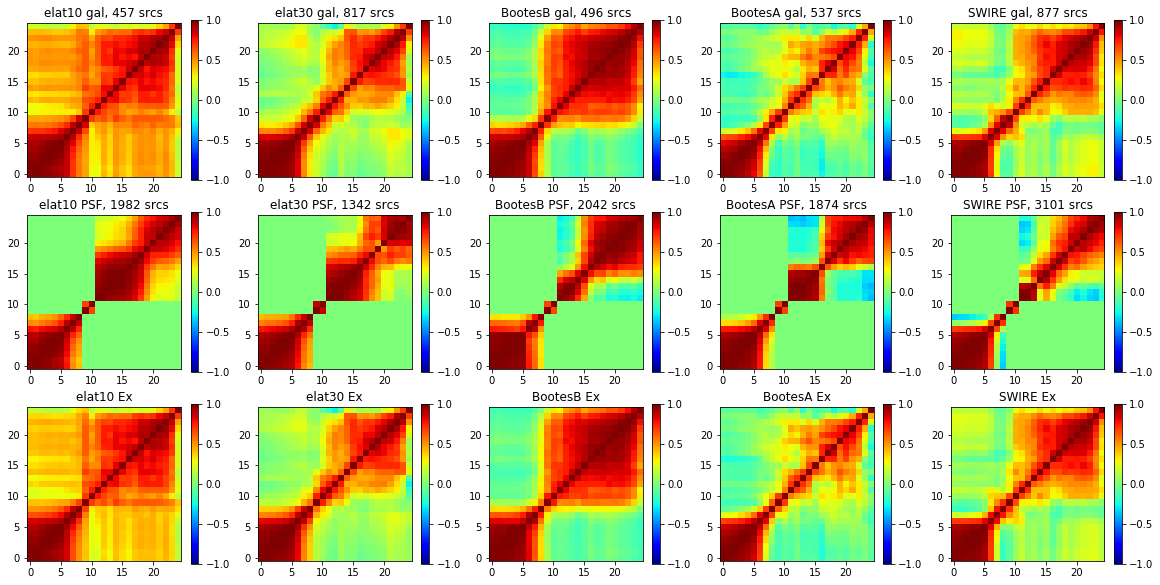

In [1]:
from stack import *

inst = 1
fig, ax = plt.subplots(3,5,figsize=(20,10))
for i,ifield in enumerate([4,5,6,7,8]):
    stackdat = stacking(1,ifield,18,19,filt_order=3,load_from_file=True,
                        BGsub=False).stackdat
    imageclip(stackdat['cov']['profcb_rho'],vmin=-1, vmax=1,ax=ax[0][i])
    ax[0][i].set_title('%s gal, %d srcs'%(stackdat['field'],stackdat['Nsrc']))
    imageclip(stackdat['PSFcov']['profcb_rho'],vmin=-1, vmax=1,ax=ax[1][i])
    ax[1][i].set_title('%s PSF, %d srcs'%(stackdat['field'],stackdat['PSF']['Nsrc']))
    imageclip(stackdat['excov']['profcb_rho'],vmin=-1, vmax=1,ax=ax[2][i])
    ax[2][i].set_title('%s Ex'%(stackdat['field']))

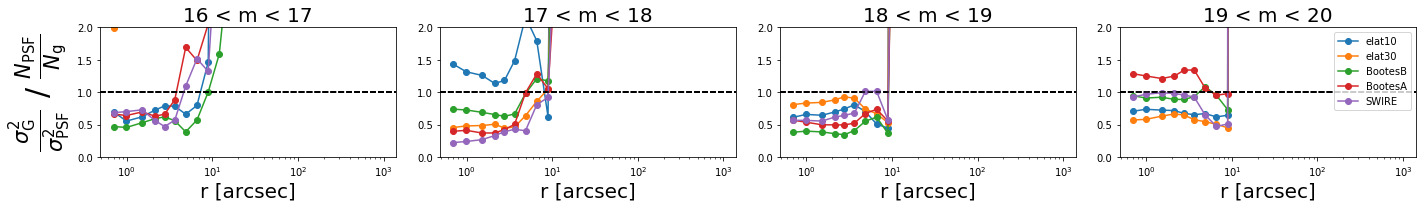

In [4]:
fig, ax = plt.subplots(1,4,figsize=(20,3))
inst = 1
for i,ifield in enumerate([4,5,6,7,8]):
    for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
        stackdat = stacking(inst,ifield,m_min,m_max,filt_order=3,
                            load_from_file=True, BGsub=False).stackdat
        gal_var = np.diag(stackdat['cov']['profcb'])
        psf_var = np.diag(stackdat['PSFcov']['profcb'])
        r_var = gal_var / psf_var 
        r_N = stackdat['PSF']['Nsrc'] / stackdat['Nsrc']
        ax[im].semilogx(stackdat['rbins'],r_var/r_N,'o-',label=fieldnamedict[ifield])
        ax[im].axhline(1,c='k',ls='--')
        ax[im].set_ylim([0, 2])
        ax[im].set_xlabel('r [arcsec]',fontsize=20)
        ax[im].set_title('%d < m < %d'%(m_min, m_max),fontsize=20)
ax[0].set_ylabel(r'$\frac{\sigma^2_{\rm G}}{\sigma^2_{\rm PSF}}\ /\ \frac{N_{\rm PSF}}{N_{\rm g}}$',
                 fontsize=30)
ax[-1].legend()
plt.tight_layout()
plt.savefig('/Users/ytcheng/Desktop/cov_scale.png', dpi = 150,bbox_inches='tight')

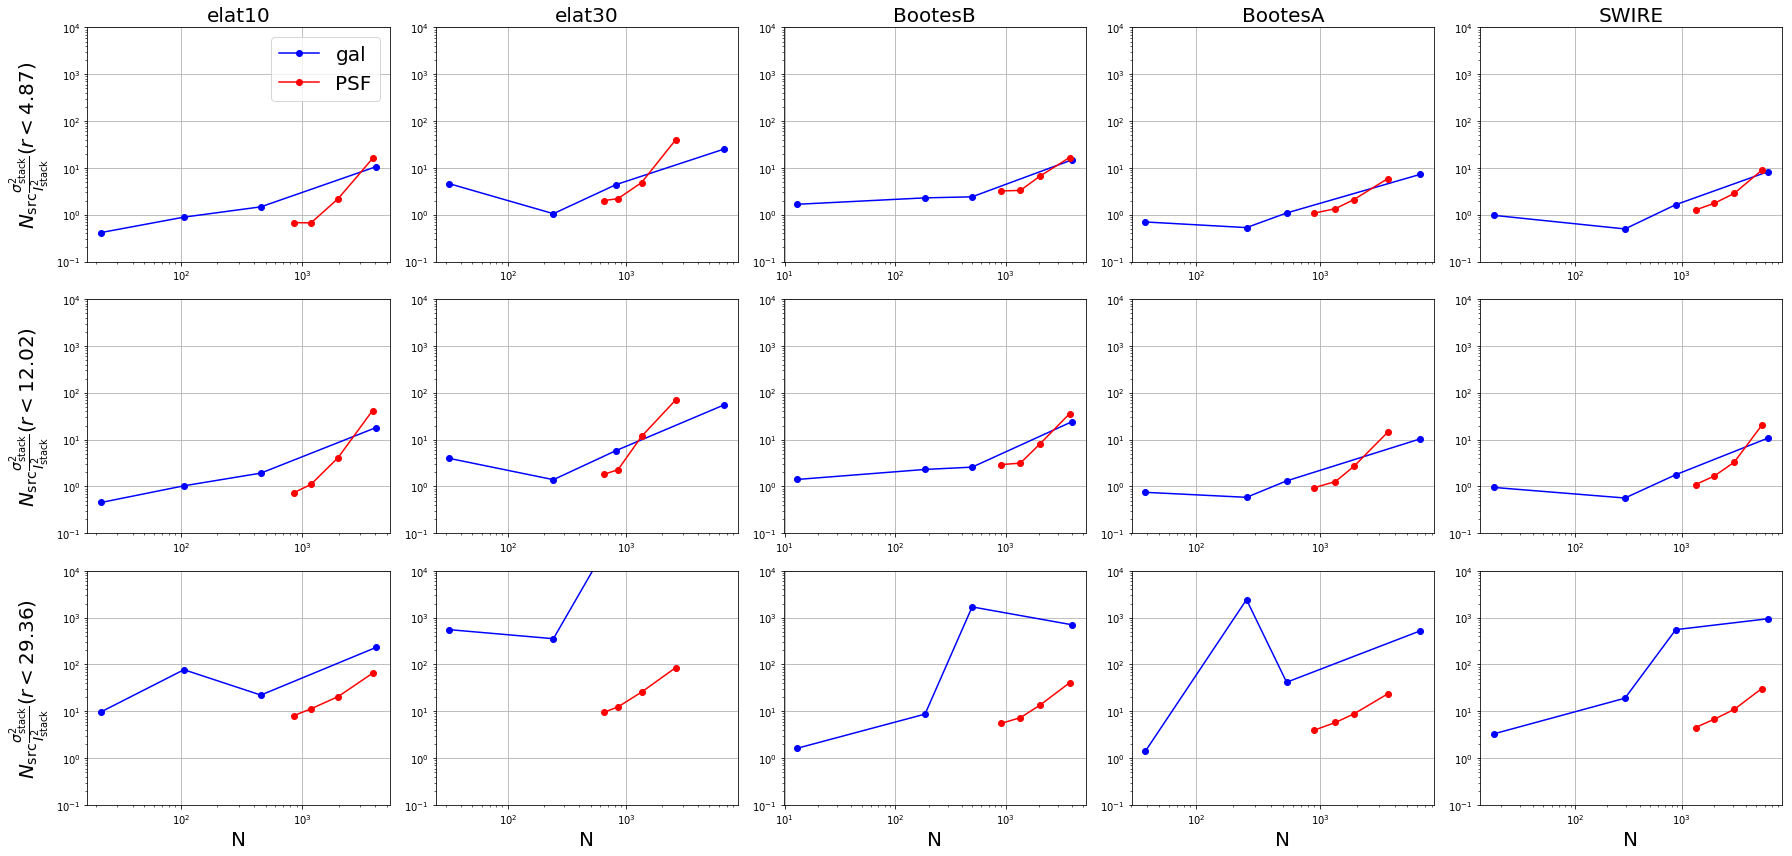

In [8]:
fig, ax = plt.subplots(3,5,figsize=(25,12))
inst = 1
for ir, avgNbins in enumerate([6,9,12]):
    for i,ifield in enumerate([4,5,6,7,8]):
        varpsf_arr, varg_arr = [], []
        Ng_arr, Npsf_arr = [], []
        for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
            stackdat = stacking(inst,ifield,m_min,m_max,filt_order=3,
                                load_from_file=True, BGsub=False).stackdat
            gal_var = np.diag(stackdat['cov']['profcb'])/stackdat['profcb']**2
            psf_var = np.diag(stackdat['PSFcov']['profcb'])/stackdat['PSF']['profcb']**2
            Ng = stackdat['Nsrc']
            Npsf = stackdat['PSF']['Nsrc']
            Ng_arr.append(Ng)
            Npsf_arr.append(Npsf)
            varg_arr.append(np.mean(gal_var[:avgNbins]))
            varpsf_arr.append(np.mean(psf_var[:avgNbins]))
    
        rlim=stackdat['rbins'][avgNbins]
        Ng_arr, Npsf_arr = np.array(Ng_arr), np.array(Npsf_arr)
        varg_arr, varpsf_arr = np.array(varg_arr), np.array(varpsf_arr)
        ax[ir][i].semilogx(Ng_arr, varg_arr*Ng_arr,'bo-',label='gal')
        ax[ir][i].loglog(Npsf_arr, varpsf_arr*Npsf_arr,'ro-',label='PSF')
        ax[ir][i].set_ylim([1e-1,1e4])
        ax[ir][i].grid()
        ax[-1][i].set_xlabel('N',fontsize=20)
        ax[0][i].set_title(fieldnamedict[ifield],fontsize=20)
    ax[ir][0].set_ylabel(r'$N_{\rm src}\frac{\sigma^2_{\rm stack}}{I^2_{\rm stack}}(r < %.2f)$'%rlim,
                     fontsize=20)
    ax[0][0].legend(fontsize=20)
    plt.tight_layout()
plt.savefig('/Users/ytcheng/Desktop/cov_scale1.png', dpi = 150,bbox_inches='tight')

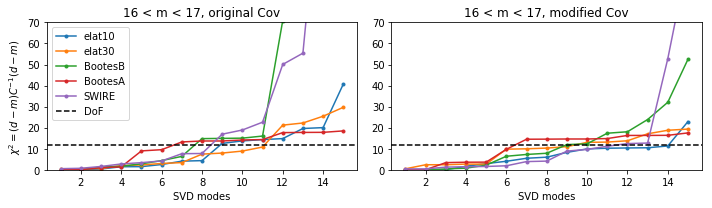

In [157]:
from stack import *
from run_fit import *
inst = 1
filt_order = 3

fig, ax = plt.subplots(1, 2, figsize = (10,3))
for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'][:1],magbindict['m_max'][:1])):
    R200 = gal_profile_model().Wang19_profile(0,im)['params']['R200']
    xe2_W19 = gal_profile_model().Wang19_profile(0,3)['params']['sersic2'][2]
    Re2_W19 = R200 * xe2_W19
    for ifield in [4,5,6,7,8]:        
        param_fit = fit_stacking_mcmc(inst, ifield, im, filt_order)
        modelprof = param_fit.get_profexcess_model(Re2=Re2_W19, A1h=1, A2h=1)
        M = modelprof['profex_sub'] + modelprof['prof1h_sub'] + modelprof['prof2h_sub']
        D = param_fit.profex_sub
        
        stackdat = stacking(inst,ifield,m_min,m_max,filt_order=filt_order,
                            load_from_file=True, BGsub=False).stackdat
        Covg = stackdat['cov']['profcbsub'].copy()
        Covpsf = stackdat['PSFcov']['profcbsub'].copy()
        Covex = stackdat['excov']['profcbsub'].copy()

        # scale = np.mean(np.diag(Covg[:4])/np.diag(Covpsf[:4]))
        scale = stackdat['PSF']['Nsrc'] / stackdat['Nsrc']
        Covg1 = Covg.copy()
        Covg1[:4,:] = Covpsf[:4,:] * scale
        Covg1[:,:4] = Covpsf[:,:4] * scale
        Covex1 = Covg1 + Covpsf
        
        Cov = Covex
        U, s, VT = np.linalg.svd(Cov)
        V = VT.T
        UT = U.T
        S = np.diag(s)
        Sinv  = np.diag(1/s)
        chi2_arr = []
        for Nmode in np.arange(len(s))+1:
            Cov_svd = U[:,:Nmode]@S[:Nmode,:Nmode]@VT[:Nmode,:]
            Covi_svd = V[:,:Nmode]@Sinv[:Nmode,:Nmode]@UT[:Nmode,:]

            chi2_mat_svd = Covi_svd * ((D-M)[:,np.newaxis] @ (D-M)[:,np.newaxis].T)
            chi2_arr.append(np.sum(chi2_mat_svd))
        ax[0].plot(np.arange(len(s))+1, chi2_arr,'.-',label=param_fit.field,C='C'+str(ifield-4))
        
        Cov = Covex1
        U, s, VT = np.linalg.svd(Cov)
        V = VT.T
        UT = U.T
        S = np.diag(s)
        Sinv  = np.diag(1/s)
        chi2_arr = []
        for Nmode in np.arange(len(s))+1:
            Cov_svd = U[:,:Nmode]@S[:Nmode,:Nmode]@VT[:Nmode,:]
            Covi_svd = V[:,:Nmode]@Sinv[:Nmode,:Nmode]@UT[:Nmode,:]

            chi2_mat_svd = Covi_svd * ((D-M)[:,np.newaxis] @ (D-M)[:,np.newaxis].T)
            chi2_arr.append(np.sum(chi2_mat_svd))
        ax[1].plot(np.arange(len(s))+1, chi2_arr,'.-',label=param_fit.field,C='C'+str(ifield-4))
        
        
    ax[0].set_ylabel(r'$\chi^2 = (d-m)C^{-1}(d-m)$')
    ax[0].set_xlabel('SVD modes')
    ax[0].axhline(len(s)-3,c='k',ls='--',label='DoF')
    ax[0].set_ylim([0,70])
    ax[0].legend()
    ax[0].set_title('%d < m < %d, original Cov'%(m_min, m_max))

    ax[1].set_xlabel('SVD modes')
    ax[1].axhline(len(s)-3,c='k',ls='--',label='DoF')
    ax[1].set_ylim([0,70])
    ax[1].set_title('%d < m < %d, modified Cov'%(m_min, m_max))
plt.tight_layout()
plt.savefig('/Users/ytcheng/Desktop/cov_svd_mod.png', dpi = 150,bbox_inches='tight')

In [131]:
inst = 1
ifield = 6
im = 0
burn_in = 150

R200 = gal_profile_model().Wang19_profile(0,im)['params']['R200']

savename = 'mcmc_3par_' + fieldnamedict[ifield] + \
'_m' + str(magbindict['m_min'][im]) + '_' + str(magbindict['m_max'][im]) + '.npy'

chaindir = mypaths['alldat'] + 'TM' + str(inst) + '/'
samples = np.load(chaindir + savename)
flatsamps = samples.copy()

# chain rejection
chain_use_idx = []
Nchain = flatsamps.shape[1]
for i in range(Nchain):
    if not np.any(flatsamps[100:,i,1]>100):
        chain_use_idx.append(i)
flatsamps = flatsamps[burn_in:,chain_use_idx,:].reshape((-1,3))

# get 68 C.I.
xe2, xe2_low, xe2_high = get_posterior_interval(flatsamps[:,0])
A1h, A1h_low, A1h_high = get_posterior_interval(flatsamps[:,1])
A2h, A2h_low, A2h_high = get_posterior_interval(flatsamps[:,2])

fitparamdat_org = {'R200': R200, 'xe2': xe2, 'xe2_low': xe2_low, 'xe2_high': xe2_high,
              'Re2': xe2*R200, 'Re2_low': xe2_low*R200, 'Re2_high': xe2_high*R200,
              'A1h': A1h, 'A1h_low': A1h_low, 'A1h_high': A1h_high,
              'A2h': A2h, 'A2h_low': A2h_low, 'A2h_high': A2h_high}


savename = 'mcmc_3par_' + fieldnamedict[ifield] + \
'_m' + str(magbindict['m_min'][im]) + '_' + str(magbindict['m_max'][im]) + '_modcov.npy'

chaindir = mypaths['alldat'] + 'TM' + str(inst) + '/'
samples = np.load(chaindir + savename)
flatsamps = samples.copy()

# chain rejection
chain_use_idx = []
Nchain = flatsamps.shape[1]
for i in range(Nchain):
    if not np.any(flatsamps[100:,i,1]>100):
        chain_use_idx.append(i)
flatsamps = flatsamps[burn_in:,chain_use_idx,:].reshape((-1,3))

# get 68 C.I.
xe2, xe2_low, xe2_high = get_posterior_interval(flatsamps[:,0])
A1h, A1h_low, A1h_high = get_posterior_interval(flatsamps[:,1])
A2h, A2h_low, A2h_high = get_posterior_interval(flatsamps[:,2])

fitparamdat_mod = {'R200': R200, 'xe2': xe2, 'xe2_low': xe2_low, 'xe2_high': xe2_high,
              'Re2': xe2*R200, 'Re2_low': xe2_low*R200, 'Re2_high': xe2_high*R200,
              'A1h': A1h, 'A1h_low': A1h_low, 'A1h_high': A1h_high,
              'A2h': A2h, 'A2h_low': A2h_low, 'A2h_high': A2h_high}

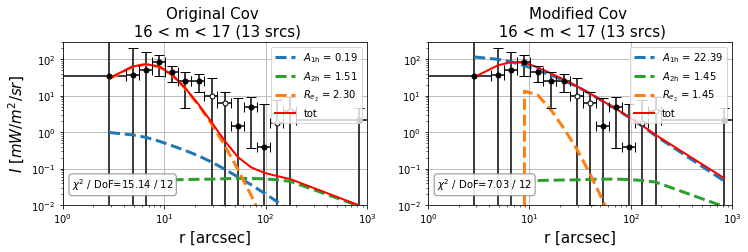

In [154]:
from run_fit import *

inst = 1
filt_order = 3
ifield = 6
im = 0
m_min, m_max = magbindict['m_min'][im],magbindict['m_max'][im]
fig, ax = plt.subplots(1, 2, figsize = (12,3))

for i in [0,1]:
    if i == 0:
        fitparamdat = fitparamdat_org.copy()
        param_fit = fit_stacking_mcmc(inst, ifield, im, filt_order)
    elif i == 1:
        fitparamdat = fitparamdat_mod.copy()
        param_fit = fit_stacking_mcmc(inst, ifield, im, filt_order,
                                     modify_cov=True)

    Re2 = fitparamdat['Re2']
    A1h = fitparamdat['A1h']
    A2h = fitparamdat['A2h']
    Nsrc = param_fit.Nsrc
    r_arr = param_fit.rsubbins
    profd_arr = param_fit.profex_sub
    profd_err = np.sqrt(np.diag(param_fit.covsub))
    modelprof = param_fit.get_profexcess_model(Re2=Re2, A1h=A1h, A2h=A2h)
    profex_arr = modelprof['profex_sub']
    prof1h_arr = modelprof['prof1h_sub']
    prof2h_arr = modelprof['prof2h_sub']
    chi2 = param_fit.get_chi2(Re2=Re2, A1h=A1h, A2h=A2h)
    rbinedges = param_fit.rsubbinedges
    dof = param_fit.dof_data - 3
    ax[i].loglog(r_arr, prof1h_arr,'C0--', lw=3, label=r'$A_{\rm 1h}$ = %.2f'%A1h)
    ax[i].loglog(r_arr, prof2h_arr,'C2--', lw=3, label=r'$A_{\rm 2h}$ = %.2f'%A2h)
    ax[i].loglog(r_arr, profex_arr,'C1--', lw=3, label=r'$R_{e_2}$ = %.2f'%Re2)
    ax[i].loglog(r_arr, profex_arr + prof1h_arr + prof2h_arr,'r-', lw=2, label = 'tot')
    ax[i].text(0.03, 0.10,r'$\chi^2$ / DoF=%.2f / %d'%(chi2,dof),transform=ax[i].transAxes,
                bbox={'boxstyle':'round','alpha':0.9, 'fc':'w','ec':'0.5'}, fontsize=10)
    plot_err_log(r_arr, 
                 profd_arr,
                 profd_err,
                 xedges = rbinedges,
                 ax=ax[i], color='k')

    if i == 0:
        ax[i].set_title('Original Cov \n %d < m < %d (%d srcs)'%(m_min, m_max, Nsrc),fontsize=15)
    elif i == 1:
        ax[i].set_title('Modified Cov \n %d < m < %d (%d srcs)'%(m_min, m_max, Nsrc),fontsize=15)
    ax[i].set_ylim([1e-2,3e2])
    ax[i].set_xlim([1e0,1e3])
    ax[i].grid()
    ax[i].legend(loc=1)
    ax[i].set_xlabel('r [arcsec]',fontsize=15)
ax[0].set_ylabel(r'$I$ [$mW/m^2/sr$]',fontsize=15)

plt.savefig('/Users/ytcheng/Desktop/profile_mod_cov.png', dpi = 150,bbox_inches='tight')

In [151]:
from run_fit import *
import corner
from PIL import Image

inst = 1
ifield = 6
im = 0
magbindict['m_min'][im],magbindict['m_max'][im]

figure1, ax = plt.subplots(3,3,figsize=(12,12))
figure2, ax = plt.subplots(3,3,figsize=(12,12))

R200 = gal_profile_model().Wang19_profile(0,im)['params']['R200']
xe2_W19 = gal_profile_model().Wang19_profile(0,3)['params']['sersic2'][2]
Re2_W19 = R200 * xe2_W19

savedir = mypaths['alldat'] + 'TM' + str(inst) + '/'

for case in [0,1]:
    if case == 0:
        savename = 'mcmc_3par_' + fieldnamedict[ifield] + \
        '_m' + str(m_min) + '_' + str(m_max) + '.npy'
    else:
        savename = 'mcmc_3par_' + fieldnamedict[ifield] + \
        '_m' + str(m_min) + '_' + str(m_max) + '_modcov.npy'
        
    c = 'C' + str(case)

    samples = np.load(savedir + savename)
    steps, nwalkers, nparams = samples.shape

    flatsamps = samples.copy()
    flatsamps[:,:,0] = flatsamps[:,:,0] * R200
    # chain rejection
    chain_use_idx = []
    Nchain = flatsamps.shape[1]
    for i in range(Nchain):
        if not np.any(flatsamps[100:,i,1]>100):
            chain_use_idx.append(i)
    flatsamps = flatsamps[150:,chain_use_idx,:].reshape((-1,3))

    bins0 = np.linspace(np.min(flatsamps[:,0]), np.max(flatsamps[:,0]), 20)
    bins1 = np.linspace(np.min(flatsamps[:,1]), np.max(flatsamps[:,1]), 20)
    bins2 = np.linspace(np.min(flatsamps[:,2]), np.max(flatsamps[:,2]), 20)

    levels= 1.0 - np.exp(-0.5 * np.array([1]) ** 2)
    figure = corner.corner(flatsamps, levels = levels,fill_contours=False,color=c,
                           plot_datapoints=False,
                           bins=[bins0, bins1, bins2],label_kwargs={'fontsize':'xx-large'},
                           range=[(0,5),(0,20),(0,200)],
                           title_kwargs={'fontsize':'x-large'},
                           show_titles=False,labels=["$R_{e_2}$", r"$A_{\rm 1h}$", r"$A_{\rm 2h}$"],
                           fig=figure1)

    levels= 1.0 - np.exp(-0.5 * np.array([2]) ** 2)
    figure = corner.corner(flatsamps, levels = levels,fill_contours=False,color=c,
                           plot_datapoints=False,
                           bins=[bins0, bins1, bins2],label_kwargs={'fontsize':'xx-large'},
                           range=[(0,5),(0,20),(0,200)],
                           title_kwargs={'fontsize':'x-large'},
                           show_titles=False,labels=["$R_{e_2}$", r"$A_{\rm 1h}$", r"$A_{\rm 2h}$"],
                           fig=figure2)

figure1.savefig('/Users/ytcheng/Desktop/mcmc_mod_cov1.png', dpi=150)
figure2.savefig('/Users/ytcheng/Desktop/mcmc_mod_cov2.png', dpi=150)

plt.close(figure1)
plt.close(figure2)

result = Image.new("RGB", (1600,800))    
for i in [0,1]:
    fname = '/Users/ytcheng/Desktop/mcmc_mod_cov'+str(i+1)+'.png'
    path = os.path.expanduser(fname)
    img = Image.open(path)
    img.thumbnail((800, 800), Image.ANTIALIAS)
    x = i * 800
    y = 0
    w, h = img.size
    result.paste(img, (x, y, x + w, y + h))
    os.remove(fname)
    
    result.save(os.path.expanduser('/Users/ytcheng/Desktop/mcmc_mod_cov.png'))